In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump, load
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append(r'D:\Hacks\re_new')

In [19]:
from src.utils import load_config, load_data, comp_score
from src.engine import get_model

config = load_config()
random_seed = config['RAND']

In [3]:
train_data = pd.read_csv('../data/raw/train.csv')
test_data = pd.read_csv('../data/raw/test.csv')
train_data.shape, test_data.shape

((909604, 16), (303202, 15))

In [4]:
train_t1, test_t1 = load_data()
train_t1.shape, test_t1.shape

((909604, 21), (303202, 20))

# Ft. Eng.

## Date time ft.eng

In [5]:
df = pd.concat([train_data, test_data], axis=0)
df.shape

(1212806, 16)

In [6]:
grps = df.groupby(['turbine_id'])

In [7]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.sort_values(by='timestamp', inplace=True)
df

,timestamp,active_power_calculated_by_converter,active_power_raw,ambient_temperature,generator_speed,generator_winding_temp_max,grid_power10min_average,nc1_inside_temp,nacelle_temp,reactice_power_calculated_by_converter,reactive_power,wind_direction_raw,wind_speed_raw,wind_speed_turbulence,turbine_id,Target
45421,2021-01-01 00:01:00,828.392253,847.524780,23.749945,1164.353088,56.914901,833.398712,23.851615,23.613581,138.066790,166.923848,228.054690,8.184143,0.535525,Turbine_108,43.430870
658721,2021-01-01 00:02:00,734.902262,751.122874,19.137422,1119.673584,55.196616,809.185425,27.618101,25.004128,124.705297,153.301956,43.115978,6.780914,0.600904,Turbine_120,40.715544
545675,2021-01-01 00:03:00,748.204336,767.003316,19.113608,1128.340881,55.682657,804.593099,27.610003,25.033796,122.845019,157.638268,43.992285,6.605300,0.533855,Turbine_120,40.706413
772206,2021-01-01 00:04:00,1115.585986,1143.363770,18.536383,1200.487305,62.660133,1161.573462,25.932306,24.076670,192.730591,224.663141,72.256642,8.286794,0.523392,Turbine_139,40.769313
245502,2021-01-01 00:06:00,975.188029,1005.913961,25.460711,1200.243095,57.926095,1018.267802,26.737586,23.928331,158.431951,196.259565,50.205800,7.899686,0.339865,Turbine_158,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554025,2021-12-31 23:58:00,635.630473,647.702566,9.400681,973.038859,49.969453,625.765503,30.920345,26.883738,106.336980,139.864756,123.650436,6.972114,0.578641,Turbine_103,42.614979
83942,2021-12-31 23:58:00,951.135590,977.182892,8.780563,1197.069234,58.330886,902.190328,20.349027,21.095316,157.545405,194.551659,78.606181,7.534583,0.606685,Turbine_105,43.700722
668082,2021-12-31 23:58:00,858.007161,885.301178,31.106428,1178.025533,59.719817,807.887004,30.799557,27.352941,146.320142,172.715530,212.963961,7.155286,0.445924,Turbine_20,43.792723
214355,2021-12-31 23:58:00,908.267832,933.286235,18.620179,1198.289958,57.573762,779.126373,30.178709,25.337340,137.384988,180.152397,69.111694,7.281371,0.530622,Turbine_13,43.219498


In [18]:
def add_features(df):
    df['timestamp'] = pd.to_datetime(df.timestamp)
    df['month'] = df.timestamp.dt.month
    df['hour'] = df.timestamp.dt.hour
    df['dayofweek'] = df.timestamp.dt.dayofweek
    df['dayofmonth'] = df.timestamp.dt.day
    df['mmtt'] = df['month'].astype(str) + '_' + df['turbine_id']
    return df

In [20]:
df = add_features(df)
df

,timestamp,active_power_calculated_by_converter,active_power_raw,ambient_temperature,generator_speed,generator_winding_temp_max,grid_power10min_average,nc1_inside_temp,nacelle_temp,reactice_power_calculated_by_converter,...,wind_direction_raw,wind_speed_raw,wind_speed_turbulence,turbine_id,Target,month,hour,dayofweek,dayofmonth,mmtt
45421,2021-01-01 00:01:00,828.392253,847.524780,23.749945,1164.353088,56.914901,833.398712,23.851615,23.613581,138.066790,...,228.054690,8.184143,0.535525,Turbine_108,43.430870,1,0,4,1,1_Turbine_108
658721,2021-01-01 00:02:00,734.902262,751.122874,19.137422,1119.673584,55.196616,809.185425,27.618101,25.004128,124.705297,...,43.115978,6.780914,0.600904,Turbine_120,40.715544,1,0,4,1,1_Turbine_120
545675,2021-01-01 00:03:00,748.204336,767.003316,19.113608,1128.340881,55.682657,804.593099,27.610003,25.033796,122.845019,...,43.992285,6.605300,0.533855,Turbine_120,40.706413,1,0,4,1,1_Turbine_120
772206,2021-01-01 00:04:00,1115.585986,1143.363770,18.536383,1200.487305,62.660133,1161.573462,25.932306,24.076670,192.730591,...,72.256642,8.286794,0.523392,Turbine_139,40.769313,1,0,4,1,1_Turbine_139
245502,2021-01-01 00:06:00,975.188029,1005.913961,25.460711,1200.243095,57.926095,1018.267802,26.737586,23.928331,158.431951,...,50.205800,7.899686,0.339865,Turbine_158,NaN,1,0,4,1,1_Turbine_158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554025,2021-12-31 23:58:00,635.630473,647.702566,9.400681,973.038859,49.969453,625.765503,30.920345,26.883738,106.336980,...,123.650436,6.972114,0.578641,Turbine_103,42.614979,12,23,4,31,12_Turbine_103
83942,2021-12-31 23:58:00,951.135590,977.182892,8.780563,1197.069234,58.330886,902.190328,20.349027,21.095316,157.545405,...,78.606181,7.534583,0.606685,Turbine_105,43.700722,12,23,4,31,12_Turbine_105
668082,2021-12-31 23:58:00,858.007161,885.301178,31.106428,1178.025533,59.719817,807.887004,30.799557,27.352941,146.320142,...,212.963961,7.155286,0.445924,Turbine_20,43.792723,12,23,4,31,12_Turbine_20
214355,2021-12-31 23:58:00,908.267832,933.286235,18.620179,1198.289958,57.573762,779.126373,30.178709,25.337340,137.384988,...,69.111694,7.281371,0.530622,Turbine_13,43.219498,12,23,4,31,12_Turbine_13


In [23]:
df.groupby(['dayofweek']).Target.mean()

dayofweek
0    46.328492
1    46.390836
2    46.332493
3    46.122673
4    46.250855
5    46.426227
6    46.442449
Name: Target, dtype: float64

# Modelling

## Data split

In [15]:
from sklearn.model_selection import cross_val_score, KFold, train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_t1.drop(['timestamp', 'Target'], axis=1), train_t1['Target'], test_size=0.2, random_state=random_seed)  # random train test split
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((727683, 19), (181921, 19), (727683,), (181921,))

In [16]:
kf = KFold(n_splits=10, random_state=random_seed, shuffle=True)
for fold, (tr_id, te_id) in enumerate(kf.split(train_t1)):
    if fold == 7:
        Xtrain_t1  = train_t1.iloc[tr_id].drop(['timestamp', 'Target'], axis=1)
        Xval_t1 = train_t1.iloc[te_id].drop(['timestamp', 'Target'], axis=1)
        ytrain_t1 = train_t1.iloc[tr_id]['Target']
        yval_t1 = train_t1.iloc[te_id]['Target']
        break

Xtrain_t1.shape, Xval_t1.shape, ytrain_t1.shape, yval_t1.shape    # evaluating on fold 7

((818644, 19), (90960, 19), (818644,), (90960,))

## Init models

In [118]:
from catboost import CatBoostRegressor
from category_encoders.target_encoder import TargetEncoder
from sklearn.compose import make_column_transformer
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

cat_cols = [ 'mmtt']

In [32]:
xt = ExtraTreesRegressor(n_estimators=55, random_state=config['RAND'], verbose=1, n_jobs=-1)
tme = TargetEncoder()
# pf = PolynomialFeatures(degree=2)
# pca = PCA(n_components=10, random_state=config['RAND'])
scaler = StandardScaler()
ct = make_column_transformer(
    (tme, cat_cols),
    remainder = 'passthrough'
)
xt_pipe = make_pipeline(
    ct,
    # scaler,
    xt
)

print(xt_pipe)   # cur baseline - 0.002435

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('targetencoder',
                                                  TargetEncoder(),
                                                  ['turbine_id', 'month',
                                                   'mmtt'])])),
                ('extratreesregressor',
                 ExtraTreesRegressor(n_estimators=55, n_jobs=-1,
                                     random_state=4567, verbose=1))])


In [119]:
xgb = XGBRegressor(tree_method='gpu_hist', random_state=config['RAND'], n_estimators=3000, n_jobs=-1, verbose=False)
tme = TargetEncoder()
# pf = PolynomialFeatures(degree=2)
# pca = PCA(n_components=10, random_state=config['RAND'])
scaler = StandardScaler()
ct = make_column_transformer(
    (tme, cat_cols),
    remainder = 'passthrough'
)
xgb_pipe = make_pipeline(
    ct,
    # scaler,
    xgb
)

print(xgb_pipe)  # cur baseline - 0.005532

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('targetencoder',
                                                  TargetEncoder(),
                                                  ['mmtt'])])),
                ('xgbregressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              ga...policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=None,
                              max_leaves=None, 

## Baseline fits
- cur xgb_pipe baseline - 0.005543
- cur xt_pipe baseline - 0.002435

In [31]:
xgb_pipe.fit(Xtrain_t1, ytrain_t1)
xgb_preds = xgb_pipe.predict(Xval_t1)
print(comp_score(yval_t1, xgb_preds))
# fit time - 1ms

[17:46:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


0.005543603346135948


In [33]:
xt_pipe.fit(Xtrain_t1, ytrain_t1)
xt_preds = xt_pipe.predict(Xval_t1)
print(comp_score(yval_t1, xt_preds))
# fit time - 4m33s

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:  4.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   13.6s


0.0024672581409048173


[Parallel(n_jobs=8)]: Done  55 out of  55 | elapsed:   19.2s finished


In [34]:
# # temp model saving
# dump(xt_pipe, '../models/xt_pipe_t1.joblib')  # this is f***ing huge...
# dump(xgb_pipe, '../models/xgb_pipe_t1.joblib')  

['../models/xgb_pipe_t1.joblib']

## Current imp_fts

In [39]:
xt_ftimp = xt_pipe[1].feature_importances_
xgb_ftimp = xgb_pipe[1].feature_importances_

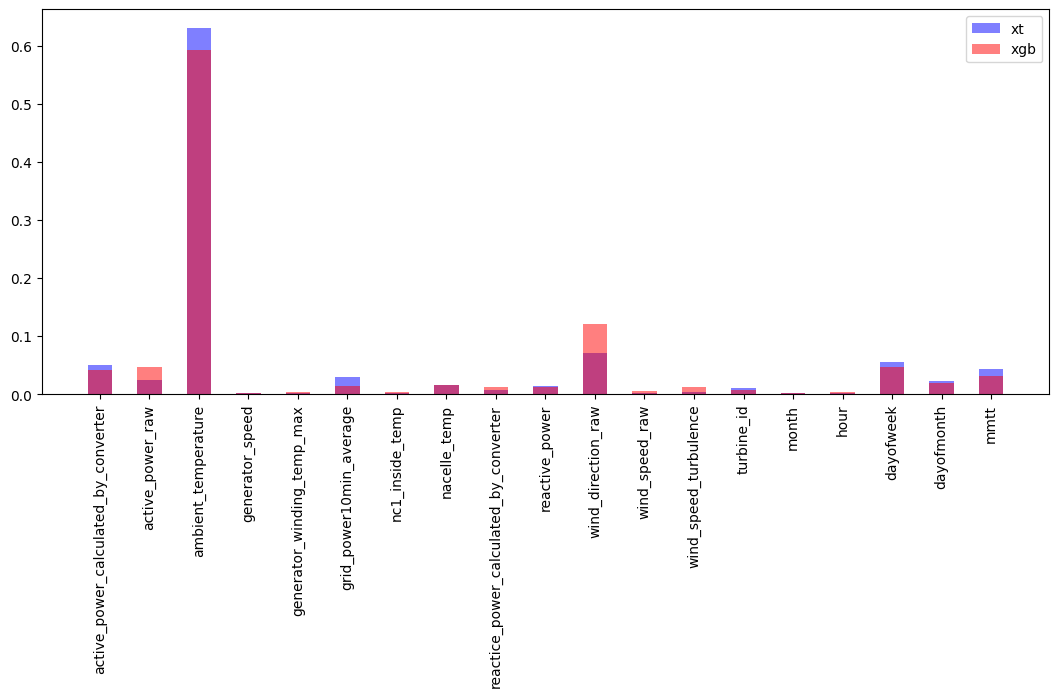

In [62]:
plt.figure(figsize=(13, 5))
plt.bar(xt_pipe.feature_names_in_, xt_ftimp, color='b', width=0.5, label='xt', alpha=0.5);
plt.bar(xgb_pipe.feature_names_in_, xgb_ftimp, color='r', width=0.5, label='xgb', alpha=0.5);
plt.xticks(rotation = 90);
plt.legend();

In [63]:
xt_ftimp

array([0.04979257, 0.02451915, 0.6312146 , 0.00321312, 0.00319002,
       0.03001068, 0.00323673, 0.01558448, 0.00834684, 0.01403249,
       0.07208248, 0.00248318, 0.00334825, 0.01157172, 0.00230557,
       0.00236268, 0.05602745, 0.02284763, 0.04383035])

In [64]:
xgb_ftimp

array([0.04172665, 0.04762521, 0.5937371 , 0.002547  , 0.00337996,
       0.01468286, 0.00408693, 0.01646376, 0.01207652, 0.01197707,
       0.1204011 , 0.00568241, 0.01198249, 0.00762321, 0.00303241,
       0.00445729, 0.0470859 , 0.02026857, 0.03116355], dtype=float32)

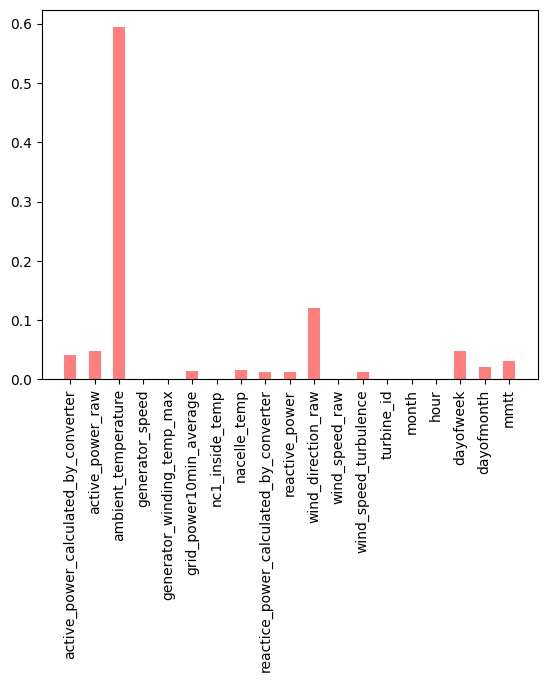

In [71]:
plt.bar(xgb_pipe.feature_names_in_, np.where(xgb_ftimp > 0.01, xgb_ftimp, 0), color='r', width=0.5, label='xgb', alpha=0.5);
plt.xticks(rotation=90);

In [104]:
ft = pd.DataFrame(index=xgb_pipe.feature_names_in_, columns=['xgb'])
ft.loc[:, 'xgb'] = xgb_ftimp
ft

,xgb
active_power_calculated_by_converter,0.041727
active_power_raw,0.047625
ambient_temperature,0.593737
generator_speed,0.002547
generator_winding_temp_max,0.003380
grid_power10min_average,0.014683
nc1_inside_temp,0.004087
nacelle_temp,0.016464
reactice_power_calculated_by_converter,0.012077
reactive_power,0.011977


In [112]:
ft.sort_values(by='xgb', ascending=False)[:12].index

Index(['ambient_temperature', 'wind_direction_raw', 'active_power_raw',
       'dayofweek', 'active_power_calculated_by_converter', 'mmtt',
       'dayofmonth', 'nacelle_temp', 'grid_power10min_average',
       'reactice_power_calculated_by_converter', 'wind_speed_turbulence',
       'reactive_power'],
      dtype='object')

In [113]:
cols = ['ambient_temperature', 'wind_direction_raw', 'active_power_raw',
       'dayofweek', 'active_power_calculated_by_converter', 'mmtt',
       'dayofmonth', 'nacelle_temp', 'grid_power10min_average',
       'reactice_power_calculated_by_converter', 'wind_speed_turbulence',
       'reactive_power']

In [117]:
Xval_t1[cols]

,ambient_temperature,wind_direction_raw,active_power_raw,dayofweek,active_power_calculated_by_converter,mmtt,dayofmonth,nacelle_temp,grid_power10min_average,reactice_power_calculated_by_converter,wind_speed_turbulence,reactive_power
0,31.694380,280.864782,834.917206,4,816.636759,2_Turbine_108,19,31.504713,917.897085,141.457644,0.544082,165.501518
28,40.831021,159.939832,50.869234,3,0.719666,9_Turbine_10,16,38.821362,0.572808,2.252436,0.666873,1.161907
40,31.941833,309.152913,30.678087,5,43.987046,8_Turbine_158,28,32.431221,1.557272,2.193154,0.848046,0.919020
55,30.502392,275.238790,1042.760417,1,1023.602132,8_Turbine_158,24,30.245406,1131.233276,156.416464,1.339535,189.642999
63,28.499810,277.685125,1675.838481,2,1652.117472,7_Turbine_13,21,30.128001,1830.778300,304.918986,1.335802,363.121358
...,...,...,...,...,...,...,...,...,...,...,...,...
909567,26.996073,287.756917,214.550847,2,220.994184,6_Turbine_139,2,33.260492,95.169183,85.005866,0.510224,100.261312
909569,31.426266,343.362986,96.779444,1,104.699844,12_Turbine_97,21,29.416847,130.619057,86.876367,0.342147,96.601340
909595,31.858798,219.380030,214.254547,3,223.330709,8_Turbine_97,12,29.520809,388.425471,86.549025,0.479672,100.835799
909597,32.506697,99.068567,416.255020,1,416.748281,5_Turbine_108,25,32.241504,353.019704,94.939171,0.581206,117.733730


In [122]:
# how does xgb perform with last 7 cols removed..

xgb_pipe.fit(Xtrain_t1[cols], ytrain_t1)
xgb_preds_2 = xgb_pipe.predict(Xval_t1[cols])
print(comp_score(yval_t1, xgb_preds_2))

[19:14:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


0.008987016957527362


In [ ]:
# definetly a drop in performance is seen...